In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Read in the csv
df = pd.read_csv("HI-Small_Trans.csv")
df.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/01 00:20,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0
1,2022/09/01 00:20,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0
2,2022/09/01 00:00,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0
3,2022/09/01 00:02,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0
4,2022/09/01 00:06,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0


In [2]:
# Check for nulls / info for the df
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5078345 entries, 0 to 5078344
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Timestamp           object 
 1   From Bank           int64  
 2   Account             object 
 3   To Bank             int64  
 4   Account.1           object 
 5   Amount Received     float64
 6   Receiving Currency  object 
 7   Amount Paid         float64
 8   Payment Currency    object 
 9   Payment Format      object 
 10  Is Laundering       int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 426.2+ MB


Timestamp             0
From Bank             0
Account               0
To Bank               0
Account.1             0
Amount Received       0
Receiving Currency    0
Amount Paid           0
Payment Currency      0
Payment Format        0
Is Laundering         0
dtype: int64

# Feature Engineering and Temporal Behavior Extraction
- This section prepares the transaction data for machine learning by standardizing column names, engineering behavioral features, and extracting date-related patterns:

In [3]:
# Standardize the column names / Engineer features
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Count how many times each account shows up
account_tx_count = df['account'].value_counts().to_dict()
receiver_tx_count = df['account.1'].value_counts().to_dict()

df['account_tx_count'] = df['account'].map(account_tx_count)
df['receiver_tx_count'] = df['account.1'].map(receiver_tx_count)

# Convert timestamp tp datetime / Count average number of transcations per account per day
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['tx_date'] = df['timestamp'].dt.date

freq_df = df.groupby(['account', 'tx_date']).size().reset_index(name='tx_count_per_day')
avg_freq = freq_df.groupby('account')['tx_count_per_day'].mean().to_dict()

df['avg_daily_tx'] = df['account'].map(avg_freq)

# Breakdown timestamp
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['day'] = df['timestamp'].dt.day
df.head()

df.sort_values(by='account_tx_count', ascending=False).head()

,timestamp,from_bank,account,to_bank,account.1,amount_received,receiving_currency,amount_paid,payment_currency,payment_format,is_laundering,account_tx_count,receiver_tx_count,tx_date,avg_daily_tx,year,month,day
484301,2022-09-01 05:23:00,70,100428660,1241,81425C050,78.36,US Dollar,78.36,US Dollar,Credit Card,0,168672,24,2022-09-01,16867.2,2022,9,1
3153148,2022-09-06 19:07:00,70,100428660,11471,800C31600,368.14,US Dollar,368.14,US Dollar,Credit Card,0,168672,18,2022-09-06,16867.2,2022,9,6
3153215,2022-09-06 19:28:00,70,100428660,795,800F9DFB0,4701.02,US Dollar,4701.02,US Dollar,Cheque,0,168672,12,2022-09-06,16867.2,2022,9,6
3153173,2022-09-06 19:22:00,70,100428660,1244,800AF3C10,224565.26,US Dollar,224565.26,US Dollar,Cash,0,168672,34,2022-09-06,16867.2,2022,9,6
3153172,2022-09-06 19:04:00,70,100428660,1244,800AF3C10,8794.91,US Dollar,8794.91,US Dollar,Credit Card,0,168672,34,2022-09-06,16867.2,2022,9,6


In [4]:
# Descriptive stats on account transaction count
df[['account_tx_count']].describe()

,account_tx_count
count,5.078345e+06
mean,8.256829e+03
std,3.317124e+04
min,1.000000e+00
25%,2.000000e+01
50%,4.200000e+01
75%,8.000000e+01
max,1.686720e+05


# Split into train/test sets
- Dropped irrelevant columns, defined target variable, then performed stratified train/test split

In [5]:
# Split into train/test sets
from sklearn.model_selection import train_test_split
X = df.drop(columns=['timestamp', 'is_laundering', 'account', 'account.1', 'tx_date'], axis=1)
y = df['is_laundering']
 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42, stratify=y)

# Model Pipeline and Hyperparameter Tuning
- Import necessary frameworks.
- Identify categorical and numeric features.
- Apply one-hot encoding to categorical variables.
- Build a pipeline that includes preprocessing and a RandomForestClassifier.
- Define a hyperparameter grid.
- Use `StratifiedKFold` cross-validation to maintain class distribution across folds.
- Run `GridSearchCV` to find the best combination of parameters using F1 score as the evaluation metric.
- Fit the final model.


In [6]:
# Instead of sampling, will build off baseline & tune hyperparameters
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from imblearn.pipeline        import Pipeline
from sklearn.compose          import ColumnTransformer
from sklearn.preprocessing    import StandardScaler, OneHotEncoder
from sklearn.ensemble         import RandomForestClassifier

categorical_cols = ['receiving_currency', 'payment_currency', 'payment_format']
numeric_cols     = [c for c in X_train.columns if c not in categorical_cols]

# Preprocessing
preprocessor = ColumnTransformer([
    ('num', 'passthrough', numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
])

pipeline = Pipeline([
    ('preproc', preprocessor),
    ('clf',     RandomForestClassifier(
                    class_weight='balanced',
                    random_state=42,
                    n_jobs=-1
                ))
])

param_grid = {
    'clf__n_estimators': [100],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_leaf': [1, 2, 5],
    'clf__max_features': ['sqrt', 'log2']
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1',
    cv=cv,
    n_jobs=2,
    verbose=1,
    refit=True
)

search.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preproc',
                                        ColumnTransformer(transformers=[('num',
                                                                         'passthrough',
                                                                         ['from_bank',
                                                                          'to_bank',
                                                                          'amount_received',
                                                                          'amount_paid',
                                                                          'account_tx_count',
                                                                          'receiver_tx_count',
                                                                          'avg_daily_tx',
                                                                          'year',
                                                                          'month',
                                                                          'day']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['receiving_currency',
                                                                          'payment_currency',
                                                                          'payment_format'])])),
                                       ('clf',
                                        RandomForestClassifier(class_weight='balanced',
                                                               n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=2,
             param_grid={'clf__max_depth': [None, 10, 20],
                         'clf__max_features': ['sqrt', 'log2'],
                         'clf__min_samples_leaf': [1, 2, 5],
                         'clf__n_estimators': [100]},
             scoring='f1', verbose=1)

In [7]:
# Output best parameters
print("Best Parameters:", search.best_params_)
print("Baseline vs Tuned Model Comparison")

Best Parameters: {'clf__max_depth': None, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 2, 'clf__n_estimators': 100}
Baseline vs Tuned Model Comparison


# Threshold Evaluation

- Used model to predict probabilities on test set.
- Loopep through a range of thresholds to convert probabilities into binary predictions.
- At each threshold, calculated and displayed precision, recall, F1 score, and accuracy.
- Helped visualize performance trade-offs to choose an optimal decision threshold.


In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

final_model = search.best_estimator_
y_scores_search = final_model.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.10, 0.95, 0.05)

print(f"{'Threshold':>10} | {'Precision':>9} | {'Recall':>6} | {'F1-Score':>8} | {'Accuracy':>8}")
print("-" * 60)

for t in thresholds:
    y_pred_tune = (y_scores_search >= t).astype(int)
    precision = precision_score(y_test, y_pred_tune, zero_division=0)
    recall    = recall_score(y_test, y_pred_tune)
    f1        = f1_score(y_test, y_pred_tune)
    accuracy  = accuracy_score(y_test, y_pred_tune)
    print(f"{t:10.2f} | {precision:9.3f} | {recall:6.3f} | {f1:8.3f} | {accuracy:8.3f}")


 Threshold | Precision | Recall | F1-Score | Accuracy
------------------------------------------------------------
      0.10 |     0.031 |  0.809 |    0.060 |    0.974
      0.15 |     0.045 |  0.741 |    0.084 |    0.984
      0.20 |     0.065 |  0.659 |    0.118 |    0.990
      0.25 |     0.097 |  0.558 |    0.166 |    0.994
      0.30 |     0.150 |  0.467 |    0.228 |    0.997
      0.35 |     0.246 |  0.406 |    0.306 |    0.998
      0.40 |     0.392 |  0.354 |    0.372 |    0.999
      0.45 |     0.549 |  0.312 |    0.398 |    0.999
      0.50 |     0.674 |  0.268 |    0.383 |    0.999
      0.55 |     0.737 |  0.226 |    0.346 |    0.999
      0.60 |     0.796 |  0.193 |    0.311 |    0.999
      0.65 |     0.859 |  0.164 |    0.276 |    0.999
      0.70 |     0.883 |  0.131 |    0.229 |    0.999
      0.75 |     0.903 |  0.096 |    0.173 |    0.999
      0.80 |     0.912 |  0.066 |    0.124 |    0.999
      0.85 |     0.882 |  0.043 |    0.082 |    0.999
      0.90 |     0.81

# Precision-Recall Curve

- Useful for evaluating performance in imbalanced datasets.
- Shows trade-off between precision and recall across thresholds.
- Helps visually choose an optimal threshold.
- Average Precision (area under curve) summarizes performance in a single metric.


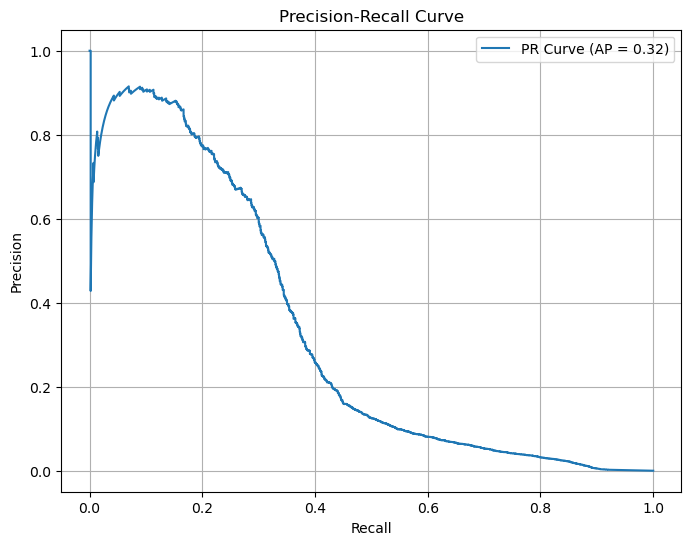

In [9]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Predict probabilities for positive class
y_scores = search.predict_proba(X_test)[:, 1]  # or use your search model

# Compute precision-recall pairs for thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Average precision (area under PR curve)
avg_prec = average_precision_score(y_test, y_scores)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AP = {avg_prec:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

# Final Evaluation at Chosen Threshold

- Apply a threshold (e.g., 0.45) to convert predicted probabilities into labels.
- Generate a classification report showing precision, recall, F1 score, and support for each class.
- Plot the confusion matrix to visualize true positives, false positives, true negatives, and false negatives.


Classification Report (Threshold = 0.45):
              precision    recall  f1-score   support

           0      0.999     1.000     1.000   1521951
           1      0.549     0.312     0.398      1553

    accuracy                          0.999   1523504
   macro avg      0.774     0.656     0.699   1523504
weighted avg      0.999     0.999     0.999   1523504



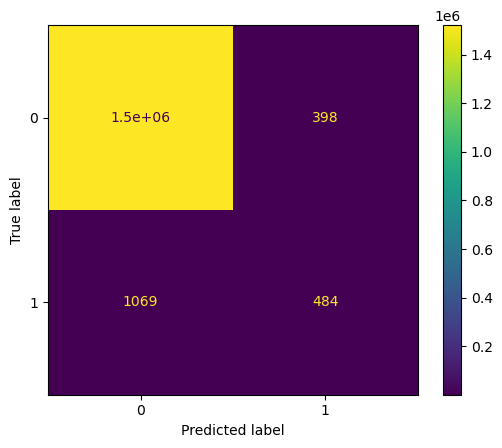

In [10]:
chosen_threshold = 0.45
y_pred = (y_scores_search >= chosen_threshold).astype(int)

# Evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

print(f"\nClassification Report (Threshold = {chosen_threshold}):")
print(classification_report(y_test, y_pred, digits=3))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Feature Importance Extraction 

- Retrieve best pipeline.
- Extract final feature names.
- Pair feature names with their importance scores.
- Sort and display the top features in descending order.

In [11]:
# Get the best pipeline from GridSearchCV
best_pipeline = search.best_estimator_

# Access the trained RandomForestClassifier
final_rf = best_pipeline.named_steps['clf']

# Access the preprocessing step to get feature names
preprocessor = best_pipeline.named_steps['preproc']
onehot_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
final_feature_names = np.concatenate([numeric_cols, onehot_feature_names])

# Zip feature importances with names and sort
importances = final_rf.feature_importances_
feature_importance_dict = dict(zip(final_feature_names, importances))
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Create and display a DataFrame
feature_importance_df = pd.DataFrame(sorted_feature_importance, columns=['Feature', 'Importance'])
print(feature_importance_df.head(20))

                           Feature  Importance
0               payment_format_ACH    0.246336
1                 account_tx_count    0.096065
2                      amount_paid    0.090132
3                  amount_received    0.086943
4                     avg_daily_tx    0.074567
5                receiver_tx_count    0.065268
6            payment_format_Cheque    0.061554
7                              day    0.057645
8       payment_format_Credit Card    0.047669
9                        from_bank    0.045398
10                         to_bank    0.039881
11     payment_format_Reinvestment    0.027090
12             payment_format_Cash    0.013142
13             payment_format_Wire    0.004727
14    payment_currency_Saudi Riyal    0.004269
15  receiving_currency_Saudi Riyal    0.003716
16      payment_currency_US Dollar    0.003190
17           payment_currency_Euro    0.002928
18         receiving_currency_Euro    0.002832
19    receiving_currency_US Dollar    0.002498


# Feature Importance Plot

- Visualize the top 20 most important features.
- A horizontal bar chart of feature names is used for better readability.
- Highlights which features contributed most to the model’s predictions.

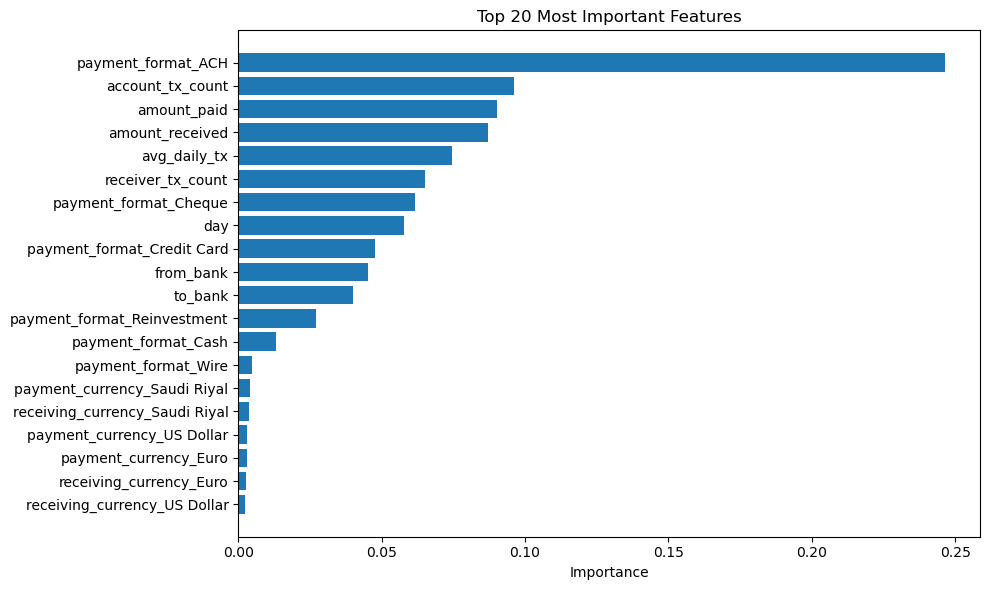

In [12]:
# Plot feature importance scores
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
top_n = 20
plt.barh(feature_importance_df['Feature'][:top_n][::-1], feature_importance_df['Importance'][:top_n][::-1])
plt.xlabel("Importance")
plt.title(f"Top {top_n} Most Important Features")
plt.tight_layout()
plt.show()

# Flagged Transactions at Threshold

- Use the chosen threshold to flag high-risk transactions.
- Add predicted probabilities and true labels to the test set.
- Filter for transactions with probabilities above the threshold.

In [14]:
threshold = chosen_threshold
y_proba = y_scores_search  

# Identify transactions
flagged_mask = y_proba >= threshold

# Create df
flagged_df = X_test.copy()
flagged_df['predicted_proba'] = y_proba
flagged_df['true_label'] = y_test.values
flagged_df = flagged_df[flagged_mask]

# Display top 20 transactions
print("Top flagged transactions at threshold =", threshold)
display(flagged_df.sort_values(by='predicted_proba', ascending=False).head(20))

Top flagged transactions at threshold = 0.45


,from_bank,to_bank,amount_received,receiving_currency,amount_paid,payment_currency,payment_format,account_tx_count,receiver_tx_count,avg_daily_tx,year,month,day,predicted_proba,true_label
5038138,48309,222,34822.31,Saudi Riyal,34822.31,Saudi Riyal,ACH,28,57,2.000000,2022,9,17,0.993360,1
2986782,49365,119,32736.73,Saudi Riyal,32736.73,Saudi Riyal,ACH,23,20,2.555556,2022,9,6,0.990760,1
5038135,150240,48309,60777.80,Saudi Riyal,60777.80,Saudi Riyal,ACH,27,57,2.250000,2022,9,14,0.983402,1
3411038,222,50202,44833.06,Saudi Riyal,44833.06,Saudi Riyal,ACH,8,47,1.600000,2022,9,7,0.983396,0
2397604,50528,148350,38558.59,Saudi Riyal,38558.59,Saudi Riyal,ACH,14,51,2.000000,2022,9,6,0.981148,0
5054176,148350,148350,45363.72,Saudi Riyal,45363.72,Saudi Riyal,ACH,23,51,2.300000,2022,9,11,0.972190,0
3625785,148350,50528,36401.32,Saudi Riyal,36401.32,Saudi Riyal,ACH,23,32,2.300000,2022,9,8,0.971739,0
2196202,119,48309,23432.41,Saudi Riyal,23432.41,Saudi Riyal,ACH,37,57,3.083333,2022,9,6,0.969848,1
4296463,148350,148350,19296.88,Saudi Riyal,19296.88,Saudi Riyal,ACH,23,51,2.300000,2022,9,11,0.961872,1
4296465,50528,148350,66793.17,Saudi Riyal,66793.17,Saudi Riyal,ACH,14,51,2.000000,2022,9,11,0.961844,1
